# Max 2-Sat

For the problem representation we used a standard format, widely accepted for boolean formulas in CNF, called [DIMACS](https://www.cs.utexas.edu/users/moore/acl2/manuals/current/manual/index-seo.php/SATLINK____DIMACS).

`usage` : change `PATH` variable, in the cell containing parameters, to choose the file of the problem you want to solve



In [1]:
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
from neal import SimulatedAnnealingSampler

import numpy as np
import dwavebinarycsp
import dimod

In [2]:
# parameters

TOKEN = 'DEV-dadab771e1ad528a25146defb4c58b1e0fe50b33' # API dwave
#PATH = 'testing_sat/04-sat.txt' # current problem to solve
#PATH = 'testing_sat/benchmarks/s2v120c1200-1.cnf'
PATH = 'testing_sat/benchmarks/s2v120c2600-1.cnf'
SAT_PATH = 'testing_sat/'
NUM_READS_SQA = 20
NUM_READS_QPU = 40
CHAIN_STRENGTH = 8

# Create QUBO

In order to create the QUBO of a MAX 2 SAT problem we followed [Glover 2019](https://arxiv.org/pdf/1811.11538.pdf). The formulas to convert traditional constraints into quadratic penalties can be found on page 15:


1. No negations: 
    Example $\left(x_{i} \vee x_{j}\right)$ 
    * Traditional constraint: $x_{i}+x_{j} \geq 1$ 
    * Quadratic Penalty: $\left(1-x_{i}-x_{j}+x_{i} x_{j}\right)$
2. One negation:
    Example $\left(x_{i} \vee \bar{x}_{j}\right)$
    * Traditional constraint: $x_{i}+\bar{x}_{j} \geq 1$
    * Quadratic Penalty: $\left(x_{j}-x_{i} x_{j}\right)$
3. Two negations: 
    Example $\left(\bar{x}_{i} \vee \bar{x}_{j}\right)$ 
    * Traditional constraint: $\bar{x}_{i}+\bar{x}_{j} \geq 1$
    * Quadratic Penalty: $\left(x_{i} x_{j}\right)$


In [3]:
# extract clauses and num of variables from 
def extract_clauses(path):
    with open(path, "r") as f:
        # retrieve data from file
        sat = f.readlines()
        data = sat[0].split(" ")

    n_variables = int(data[2]) 

    sat = sat[1:]
    clauses = [x.replace(' 0\n', '') for x in sat]
    
    return clauses, n_variables

clauses, n_variables = extract_clauses(PATH) 
print(f'num_clauses {len(clauses)}')
print('-' * 30)  
print(f'num var {n_variables}')  
print('-' * 30)  
print(f'clauses {clauses}')  

num_clauses 2600
------------------------------
num var 120
------------------------------
clauses ['-13 120', '90 -85', '10 112', '-95 -111', '-105 -93', '47 110', '-98 -112', '-71 -41', '-40 62', '-27 15', '-7 -48', '-38 47', '20 -52', '-41 59', '-50 -82', '-3 49', '111 49', '64 -40', '87 120', '47 -113', '44 -47', '-105 108', '70 -65', '-114 -116', '44 -46', '85 54', '54 -109', '101 83', '-10 -57', '45 -90', '-35 63', '58 -59', '-105 -14', '-67 -26', '-14 -56', '19 24', '81 7', '-97 51', '114 63', '2 -52', '65 2', '28 55', '111 110', '14 -55', '-61 60', '111 -96', '39 88', '20 -68', '-69 -81', '16 107', '97 -53', '-107 52', '-112 -62', '-38 -13', '-101 120', '-67 24', '-104 -61', '48 8', '61 20', '-72 -98', '40 -58', '71 11', '11 -31', '-54 17', '77 84', '92 42', '-62 42', '-20 51', '109 1', '-11 51', '-82 42', '59 71', '35 90', '12 -48', '-90 -116', '47 42', '-43 65', '-116 -84', '-6 -53', '-3 26', '115 99', '-27 -81', '-77 46', '87 33', '-98 -11', '95 -18', '70 -23', '-48 3', '102

In [4]:
# generate the matrix Q and c

def gen_q(clauses, n_variables):
    
    Q = np.zeros(shape=(n_variables, n_variables))
    c = 0
    for clause in clauses:
        clause = clause.split(' ')
        int_clause = [int(c) for c in clause]

        s1, s2 = int_clause[0], int_clause[1]
        v1, v2 = abs(s1)-1, abs(s2)-1
        

        if s1 > 0 and s2 > 0: # True True
            # 1 - x1 - x2 + x1x2
            c += 1
            Q[v1][v1] += -1 
            Q[v2][v2] += -1
            Q[v1][v2] += 1/2 
            Q[v2][v1] += 1/2
        elif s1 > 0 and s2 < 0: # True False
            # x2 - x1x2
            Q[v2][v2] += 1
            Q[v1][v2] += -1/2 
            Q[v2][v1] += -1/2

        elif s1 < 0 and s2 > 0: # False True
            # x1 - x1x2
            Q[v1][v1] += 1
            Q[v1][v2] += -1/2 
            Q[v2][v1] += -1/2

        elif s1 < 0 and s2 < 0: # False False
            # x1x2
            Q[v1][v2] += 1/2 
            Q[v2][v1] += 1/2

        else:
            pass # throw error
            
    return Q, c

Q, c = gen_q(clauses, n_variables)

print(f'Q is: \n{Q}')
print('-' * 25)
print(f'c is {c}')


Q is: 
[[-11.   -0.5  -0.5 ...   0.    0.5   0.5]
 [ -0.5  -1.    0.  ...   0.    0.5   0. ]
 [ -0.5   0.    1.  ...   0.    0.   -0.5]
 ...
 [  0.    0.    0.  ...   0.    0.    0.5]
 [  0.5   0.5   0.  ...   0.    0.    0. ]
 [  0.5   0.   -0.5 ...   0.5   0.   -1. ]]
-------------------------
c is 640


## Create BQM

In [5]:
# Create BQM
variable_order = ["x_{}".format(n) for n in range(1, n_variables+1)]
BQM = dimod.BinaryQuadraticModel.from_numpy_matrix(Q, variable_order = variable_order)
BQM

BinaryQuadraticModel({x_1: -11.0, x_2: -1.0, x_3: 1.0, x_4: 8.0, x_5: -1.0, x_6: 1.0, x_7: 2.0, x_8: -6.0, x_9: -2.0, x_10: 3.0, x_11: 4.0, x_12: -4.0, x_13: -8.0, x_14: 5.0, x_15: -3.0, x_16: -4.0, x_17: -1.0, x_18: -2.0, x_19: 2.0, x_20: -3.0, x_21: 6.0, x_22: 1.0, x_23: 0.0, x_24: -4.0, x_25: 1.0, x_26: 1.0, x_27: 5.0, x_28: -2.0, x_29: 2.0, x_30: 0.0, x_31: 6.0, x_32: -1.0, x_33: -8.0, x_34: 7.0, x_35: -1.0, x_36: -4.0, x_37: -6.0, x_38: 2.0, x_39: -2.0, x_40: 1.0, x_41: -1.0, x_42: 0.0, x_43: -2.0, x_44: -11.0, x_45: -4.0, x_46: -5.0, x_47: -9.0, x_48: 7.0, x_49: 3.0, x_50: 0.0, x_51: -1.0, x_52: -1.0, x_53: 4.0, x_54: 5.0, x_55: -2.0, x_56: 1.0, x_57: -9.0, x_58: 6.0, x_59: -2.0, x_60: -1.0, x_61: 7.0, x_62: -2.0, x_63: 2.0, x_64: 1.0, x_65: 5.0, x_66: 8.0, x_67: 6.0, x_68: -2.0, x_69: 1.0, x_70: -3.0, x_71: -11.0, x_72: -4.0, x_73: 0.0, x_74: 0.0, x_75: -3.0, x_76: 0.0, x_77: -1.0, x_78: 0.0, x_79: 5.0, x_80: -2.0, x_81: 5.0, x_82: 5.0, x_83: -3.0, x_84: -7.0, x_85: 3.0, x_86: 1

# Solve

We now solve the problem through both simulated and real quantum annealing showing the results obtained.  

In [6]:
def print_response_data(response):
    # ------- Print results to user -------
    print('-' * 160)
    print('{:>40s}{:>40s}{:^40s}{:^40s}'.format('Set 0','Set 1','Energy',"Count"))
    print('-' * 160)
    for sample, E, occ in response.data(fields=['sample','energy',"num_occurrences"]):
        S0 = [k for k,v in sample.items() if v == 0]
        S1 = [k for k,v in sample.items() if v == 1]
        print('{:>40s}{:>40s}{:^40s}{:^40s}'.format(str(S0),str(S1),str(E),str(occ)))

## Simulated Quantum Annealing

In [7]:
def simulated_annealing(bqm):
    # Run the QUBO on the solver from your config file
    sampler = SimulatedAnnealingSampler()
    response_SQA = sampler.sample(bqm, num_reads=NUM_READS_SQA, chain_strength=CHAIN_STRENGTH)
    return response_SQA

## Real Quantum Annealing

In [8]:
def real_annealing(bqm):
    # Run the QUBO on the solver from your config file
    sampler = EmbeddingComposite(DWaveSampler(token=TOKEN))

    response_QPU = sampler.sample(bqm, num_reads=NUM_READS_QPU, chain_strength=CHAIN_STRENGTH)
    return response_QPU

# Results
In the result we select the most frequent solution and we show both the optimal number of unsatisfied constraints and the assignment of the optimal solution

In [9]:
# retrieve result with the best counts

def return_solution(response, Q, c):
    count = 0
    for i in range(len(response)):
        new_count = response[i][2]
        if  new_count > count:
            best = response[i][0]
            count = new_count
    
    y = c + np.matmul(np.matmul(best.T, Q), best) 

    return y, best

def print_solution_simulation(response, Q, c):
    y, best = return_solution(response.aggregate().record, Q, c)
    print(f'y is {int(y)} (optimal number of unsitisfied constraints)')

    for v in range(n_variables):
        print(f'x_{v+1} = {True if best[v] else False}')


def print_solution_real(response, Q, c):
    y, best = return_solution(response.record, Q, c)
    print(f'y is {int(y)} (optimal number of unsitisfied constraints)')

    for v in range(n_variables):
        print(f'x_{v+1} = {True if best[v] else False}')

def compare_simulation_real(resp_simulation, resp_real, Q, c):
    y_sim, best_sim = return_solution(resp_simulation.aggregate().record, Q, c)
    y_real, best_real = return_solution(resp_real.record, Q, c)
    print(f'y simulation is {int(y_sim)}, y real is {int(y_real)} (optimal number of unsitisfied constraints)')

    sim_assignment = [best_sim[v] for v in range(n_variables)]
    real_assignment = [best_real[v] for v in range(n_variables)]
    
    count = 0
    for s, r in zip(sim_assignment, real_assignment):
        if r == s: count += 1

    print(f'real and simulation assignment differ by: {count}')

    

## Simulated Quantum Annealing

In [10]:
response_SQA = simulated_annealing(BQM)

In [11]:
print_response_data(response_SQA.aggregate())

----------------------------------------------------------------------------------------------------------------------------------------------------------------
                                   Set 0                                   Set 1                 Energy                                  Count                  
----------------------------------------------------------------------------------------------------------------------------------------------------------------
['x_101', 'x_103', 'x_107', 'x_108', 'x_109', 'x_11', 'x_111', 'x_113', 'x_114', 'x_116', 'x_117', 'x_119', 'x_14', 'x_17', 'x_19', 'x_2', 'x_21', 'x_22', 'x_23', 'x_25', 'x_26', 'x_27', 'x_29', 'x_3', 'x_30', 'x_31', 'x_32', 'x_33', 'x_34', 'x_35', 'x_38', 'x_39', 'x_4', 'x_45', 'x_48', 'x_5', 'x_53', 'x_6', 'x_61', 'x_62', 'x_63', 'x_65', 'x_66', 'x_67', 'x_71', 'x_72', 'x_74', 'x_77', 'x_79', 'x_81', 'x_82', 'x_85', 'x_87', 'x_88', 'x_89', 'x_9', 'x_91', 'x_92', 'x_93', 'x_97', 'x_98', 'x_99']['x_1', 'x_10', 

In [12]:
print_solution_simulation(response_SQA, Q, c)

y is 647 (optimal number of unsitisfied constraints)
x_1 = True
x_2 = False
x_3 = True
x_4 = False
x_5 = True
x_6 = False
x_7 = False
x_8 = True
x_9 = False
x_10 = False
x_11 = True
x_12 = False
x_13 = False
x_14 = True
x_15 = False
x_16 = True
x_17 = True
x_18 = False
x_19 = True
x_20 = False
x_21 = False
x_22 = True
x_23 = False
x_24 = True
x_25 = False
x_26 = True
x_27 = False
x_28 = True
x_29 = True
x_30 = False
x_31 = True
x_32 = False
x_33 = False
x_34 = True
x_35 = False
x_36 = False
x_37 = False
x_38 = True
x_39 = False
x_40 = False
x_41 = False
x_42 = True
x_43 = False
x_44 = False
x_45 = False
x_46 = False
x_47 = True
x_48 = False
x_49 = False
x_50 = False
x_51 = True
x_52 = True
x_53 = False
x_54 = False
x_55 = False
x_56 = False
x_57 = True
x_58 = True
x_59 = True
x_60 = True
x_61 = True
x_62 = False
x_63 = True
x_64 = False
x_65 = True
x_66 = True
x_67 = True
x_68 = False
x_69 = False
x_70 = False
x_71 = True
x_72 = True
x_73 = False
x_74 = True
x_75 = False
x_76 = False
x

## Real Quantum Annealing


In [13]:
response_QPU = real_annealing(BQM)

In [14]:
print_response_data(response_QPU)

----------------------------------------------------------------------------------------------------------------------------------------------------------------
                                   Set 0                                   Set 1                 Energy                                  Count                  
----------------------------------------------------------------------------------------------------------------------------------------------------------------
['x_100', 'x_101', 'x_102', 'x_103', 'x_104', 'x_106', 'x_107', 'x_11', 'x_110', 'x_111', 'x_113', 'x_114', 'x_117', 'x_118', 'x_120', 'x_14', 'x_17', 'x_18', 'x_19', 'x_21', 'x_22', 'x_23', 'x_25', 'x_28', 'x_29', 'x_30', 'x_31', 'x_32', 'x_33', 'x_34', 'x_35', 'x_38', 'x_39', 'x_4', 'x_42', 'x_45', 'x_48', 'x_49', 'x_5', 'x_50', 'x_52', 'x_54', 'x_56', 'x_57', 'x_59', 'x_6', 'x_61', 'x_62', 'x_63', 'x_64', 'x_65', 'x_66', 'x_67', 'x_70', 'x_71', 'x_75', 'x_78', 'x_79', 'x_8', 'x_83', 'x_85', 'x_87', 'x_88', 'x

In [15]:
print_solution_real(response_QPU, Q, c)

y is 626 (optimal number of unsitisfied constraints)
x_1 = True
x_2 = False
x_3 = True
x_4 = True
x_5 = False
x_6 = False
x_7 = False
x_8 = True
x_9 = False
x_10 = False
x_11 = True
x_12 = False
x_13 = True
x_14 = False
x_15 = False
x_16 = True
x_17 = False
x_18 = False
x_19 = False
x_20 = True
x_21 = False
x_22 = False
x_23 = True
x_24 = True
x_25 = True
x_26 = True
x_27 = False
x_28 = True
x_29 = True
x_30 = True
x_31 = False
x_32 = False
x_33 = True
x_34 = True
x_35 = False
x_36 = True
x_37 = False
x_38 = True
x_39 = False
x_40 = True
x_41 = False
x_42 = False
x_43 = False
x_44 = True
x_45 = False
x_46 = True
x_47 = False
x_48 = True
x_49 = False
x_50 = True
x_51 = False
x_52 = True
x_53 = False
x_54 = False
x_55 = False
x_56 = True
x_57 = True
x_58 = False
x_59 = False
x_60 = True
x_61 = False
x_62 = True
x_63 = True
x_64 = False
x_65 = False
x_66 = False
x_67 = True
x_68 = True
x_69 = True
x_70 = True
x_71 = True
x_72 = False
x_73 = False
x_74 = True
x_75 = False
x_76 = True
x_77 

# Visualization

In [16]:
# solution comparison

compare_simulation_real(response_SQA, response_QPU, Q, c)

y simulation is 647, y real is 626 (optimal number of unsitisfied constraints)
real and simulation assignment differ by: 72


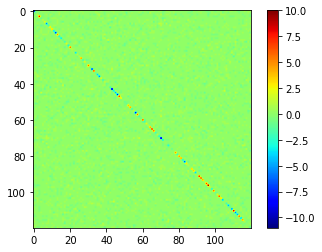

In [17]:
from matplotlib import pyplot as plt

plt.imshow(Q, cmap='jet')
plt.colorbar()

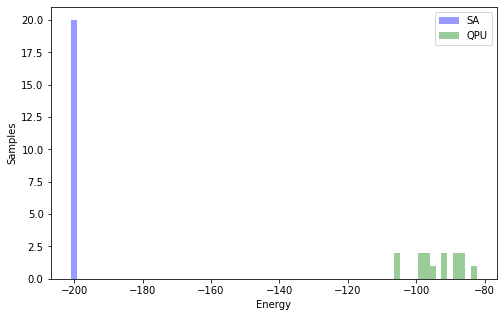

In [18]:
num_bins = 100
use_bin = 70

def histogram_energies(sampleset_SA, sampleset_QPU):
    "Plot energy histograms for both QPUs."

    fig = plt.figure(figsize=(8, 5))
    SA = sampleset_SA.record.energy
    QPU = sampleset_QPU.record.energy

    bins=np.histogram(np.hstack((SA,QPU)), bins=num_bins)[1]

    ax = fig.add_subplot(1, 1, 1)

    ax.hist(SA, bins[0:use_bin], color='b', alpha=0.4, label="SA")
    ax.hist(QPU, bins[0:use_bin], color='g', alpha=0.4, label="QPU")

    ax.set_xlabel("Energy")
    ax.set_ylabel("Samples")
    ax.legend()
    plt.show()

histogram_energies(response_SQA, response_QPU)

In [19]:
print(response_SQA.record.energy)
print(response_QPU.record.energy)
for q in response_QPU.aggregate().data():
    print(q)

[-201. -201. -201. -201. -201. -201. -200. -201. -201. -201. -200. -201.
 -201. -201. -201. -201. -201. -201. -201. -201.]
[ -96.  -89.  -82.  -91.  -97. -106.  -98. -106.  -67.  -83.  -99.  -97.
  -57.  -61.  -68.  -82.  -50.  -60.  -92.  -89.  -43.  -60.  -70.  -65.
  -61.  -57.  -61.  -77.  -60.  -87.  -43.  -69.  -80.  -87.  -56.  -50.
  -48.  -29.  -49.  -68.]
Sample(sample={'x_1': 1, 'x_10': 1, 'x_100': 0, 'x_101': 0, 'x_102': 0, 'x_103': 0, 'x_104': 0, 'x_105': 1, 'x_106': 0, 'x_107': 0, 'x_108': 1, 'x_109': 1, 'x_11': 0, 'x_110': 0, 'x_111': 0, 'x_112': 1, 'x_113': 0, 'x_114': 0, 'x_115': 1, 'x_116': 1, 'x_117': 0, 'x_118': 0, 'x_119': 1, 'x_12': 1, 'x_120': 0, 'x_13': 1, 'x_14': 0, 'x_15': 1, 'x_16': 1, 'x_17': 0, 'x_18': 0, 'x_19': 0, 'x_2': 1, 'x_20': 1, 'x_21': 0, 'x_22': 0, 'x_23': 0, 'x_24': 1, 'x_25': 0, 'x_26': 1, 'x_27': 1, 'x_28': 0, 'x_29': 0, 'x_3': 1, 'x_30': 0, 'x_31': 0, 'x_32': 0, 'x_33': 0, 'x_34': 0, 'x_35': 0, 'x_36': 1, 'x_37': 1, 'x_38': 0, 'x_39': 0, 'x_4'

# Testing

In [20]:
# define the csp
csp = dwavebinarycsp.factories.random_2in4sat(4, 2) # 8 variables, 4 clauses
csp

In [21]:
# define the csp
csp = dwavebinarycsp.factories.random_2in4sat(4, 2) 
print(type(csp))
for i in range(len(csp.constraints)):
    print(csp.constraints[i])

# generate the bqm from the csp
import warnings
np.warnings.filterwarnings("ignore", category=DeprecationWarning)

bqm = dwavebinarycsp.stitch(csp)
bqm

<class 'dwavebinarycsp.core.csp.ConstraintSatisfactionProblem'>
Constraint.from_configurations(frozenset({(0, 0, 1, 0), (0, 1, 1, 1), (1, 0, 1, 1), (0, 1, 0, 0), (1, 0, 0, 0), (1, 1, 0, 1)}), (0, 2, 3, 1), Vartype.BINARY, name='2-in-4')
Constraint.from_configurations(frozenset({(0, 0, 0, 1), (0, 0, 1, 0), (1, 0, 1, 1), (0, 1, 0, 0), (1, 1, 1, 0), (1, 1, 0, 1)}), (0, 1, 2, 3), Vartype.BINARY, name='2-in-4')


BinaryQuadraticModel({0: 4.0, 1: 4.0, 2: -4.0, 3: -4.0}, {(0, 1): -8.0, (0, 2): 0.0, (0, 3): 0.0, (1, 2): 0.0, (1, 3): 0.0, (2, 3): 8.0}, 4.0, 'BINARY')

In [22]:
resp_san = simulated_annealing(bqm)
#resp_qpu = real_annealing(bqm)

print_response_data(resp_san.aggregate())
#print_response_data(resp_qpu.aggregate())


----------------------------------------------------------------------------------------------------------------------------------------------------------------
                                   Set 0                                   Set 1                 Energy                                  Count                  
----------------------------------------------------------------------------------------------------------------------------------------------------------------
                                     [3]                               [0, 1, 2]                  0.0                                      8                    
                                     [2]                               [0, 1, 3]                  0.0                                      3                    
                               [0, 1, 3]                                     [2]                  0.0                                      6                    
                               [0,

In [24]:
print(response_QPU.info["timing"])

{'qpu_sampling_time': 5787, 'qpu_anneal_time_per_sample': 20, 'qpu_readout_time_per_sample': 104, 'qpu_access_time': 21592, 'qpu_access_overhead_time': 18396, 'qpu_programming_time': 15805, 'qpu_delay_time_per_sample': 21, 'total_post_processing_time': 629, 'post_processing_overhead_time': 74}


In [1]:
time_labels = ['qpu_sampling_time', 
'qpu_anneal_time_per_sample', 
'qpu_readout_time_per_sample', 
'qpu_access_time', 
'qpu_access_overhead_time', 
'qpu_programming_time', 
'qpu_delay_time_per_sample', 
'total_post_processing_time', 
'post_processing_overhead_time']

total_time = 0
for t in time_labels:
    time = response_QPU.info["timing"][t]
    print(f'{t}: {time}')
    total_time += time
print(f'total time: {total_time}') 

NameError: name 'response_QPU' is not defined